In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import xarray as xr
import metpy
from metpy.units import units
import iris
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import cfgrib
import xesmf as xe
import xgeo
import pyproj
import ESMF
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [2]:
cluster = SLURMCluster()
cluster.scale(1)
client = Client(cluster)

In [3]:
# Grab NAM Coordinates from reanalysis dataset on Keeling
nam_including_coords_ds = xr.open_dataset('/data/meso/a/jtrapp/formax/namanl_218_20100510_1200_000.grb', engine='cfgrib',
                                           backend_kwargs={
                                                            'filter_by_keys': {'cfName': 'eastward_wind', 'typeOfLevel': 'isobaricInhPa'},
                                                            'errors': 'ignore'
                                                            }
                                         )
ds_out = nam_including_coords_ds.rename({'isobaricInhPa': 'plev', 'longitude': 'lon', 'latitude': 'lat'})

In [4]:
base_url = 'https://www.ncei.noaa.gov/thredds/dodsC/namanl/'
dt = datetime(2009, 5, 7, 18)
nam_data = xr.open_dataset('{}{dt:%Y%m}/{dt:%Y%m%d}/namanl_218_{dt:%Y%m%d}_'
                       '{dt:%H}00_000.grb'.format(base_url, dt=dt),
                       decode_times=True)

nam_temp = nam_data.metpy.parse_cf('Temperature_isobaric')[0]
nam_crs = nam_temp.metpy.cartopy_crs

In [5]:
def monthly_average(ds_in, variable, start_year=1990, end_year=1999, month_num=5):
    """
    Takes the input xarray dataset, converts the times from cftimes to
    datetime objects. It then subsets the time based on the given years, 
    and calculates the monthly averages
    """
    
    # Converts the cftimes to datetime
    ds_in['time'] = ds_in.indexes['time'].to_datetimeindex()
    
    # Subsets times based on given years
    ds_in = ds_in.sel(time = slice(datetime(start_year, 1, 16, 12),
                                   datetime(end_year, 12, 16, 12 )))
    
    # Find the monthly average
    monthly_avg = ds_in[variable].groupby('time.month').mean('time')
    
    mon_avg = monthly_avg.sel(month=month_num)
    
    mon_avg_ds = mon_avg.to_dataset()
    
    # Setup the regridder - keek reuse_weights = True to use the regridder in the directory
    regridder = xe.Regridder(mon_avg_ds, ds_out, 'bilinear', reuse_weights=True)

    return regridder(mon_avg_ds)

In [6]:
def climo_delta_soil_miroc(variable):
    # Path to the directory containing the MIROC dataset
    first_path = '/data/jtrapp/a/jtrapp/CMIP5/MIROC/'
    
    # Path to the historical data
    end_path_historical = '_Lmon_MIROC5_historical_r1i1p1_185001-201212.nc'
 
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Lmon_MIROC5_rcp85_r1i1p1_200601-210012.nc'

    # Historical U-component of the wind
    past_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()

    # Future U-component of the wind
    future_ds = xr.open_dataset(first_path + variable + end_path_future).metpy.parse_cf()
    
    return (monthly_average(future_ds, variable, 2090, 2099).interp({'depth':[0.15, 0.45, 0.75, 1.05, 1.35, 1.65]}) - 
            monthly_average(past_ds, variable).interp({'depth':[0.15, 0.45, 0.75, 1.05, 1.35, 1.65]}))

def climo_delta_soil_gfdl(variable):
    # Path to the directory containing the MIROC dataset
    directory_path = '/data/jtrapp/a/jtrapp/CMIP5/GFDL/'
    
    # End path for the historical 3d variables
    end_path_historical1 = '_Lmon_GFDL-CM3_historical_r1i1p1_199001-199412.nc'
    end_path_historical2 = '_Lmon_GFDL-CM3_historical_r1i1p1_199501-199912.nc'

    # End path for the future 3d variables
    end_path_future1 = '_Lmon_GFDL-CM3_rcp85_r1i1p1_209101-209512.nc'
    end_path_future2 = '_Lmon_GFDL-CM3_rcp85_r1i1p1_209601-210012.nc'
    
    # Historical U-component of the wind
    past_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_historical1).metpy.parse_cf(),
                               xr.open_dataset(directory_path + variable + end_path_historical2).metpy.parse_cf()], dim='time')

    # Future U-component of the wind
    future_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_future1).metpy.parse_cf(),
                           xr.open_dataset(directory_path + variable + end_path_future2).metpy.parse_cf()], dim='time')
    
    return (monthly_average(future_ds, variable, 2090, 2099).interp({'depth':[0.15, 0.45, 0.75, 1.05, 1.35, 1.65]}) - 
            monthly_average(past_ds, variable).interp({'depth':[0.15, 0.45, 0.75, 1.05, 1.35, 1.65]}))

def climo_delta_soil_ncar(variable):
    # Path to the directory containing the MIROC dataset
    first_path = '/data/jtrapp/a/jtrapp/CMIP5/NCAR/'
    
    # Path to the historical data
    end_path_historical = '_Lmon_CCSM4_historical_r1i1p1_195001-200512.nc'
 
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Lmon_CCSM4_rcp85_r1i1p1_205001-210012.nc'

    # Historical U-component of the wind
    past_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()

    # Future U-component of the wind
    future_ds = xr.open_dataset(first_path + variable + end_path_future).metpy.parse_cf()

    return (monthly_average(future_ds, variable, 2090, 2099).interp({'depth':[0.15, 0.45, 0.75, 1.05, 1.35, 1.65]}) - 
            monthly_average(past_ds, variable).interp({'depth':[0.15, 0.45, 0.75, 1.05, 1.35, 1.65]}))

In [7]:
def climo_delta_soil_percent_change_miroc(variable):
    # Path to the directory containing the MIROC dataset
    first_path = '/data/jtrapp/a/jtrapp/CMIP5/MIROC/'
    
    # Path to the historical data
    end_path_historical = '_Lmon_MIROC5_historical_r1i1p1_185001-201212.nc'
 
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Lmon_MIROC5_rcp85_r1i1p1_200601-210012.nc'

    # Historical U-component of the wind
    past_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()
    past_avg = monthly_average(past_ds, variable).interp({'depth':0.5})

    # Future U-component of the wind
    future_ds = xr.open_dataset(first_path + variable + end_path_future).metpy.parse_cf()
    future_avg = monthly_average(future_ds, variable, 2090, 2099).interp({'depth':0.5})

    return ((future_avg - past_avg)/(past_avg))*100

def climo_delta_soil_percent_change_gfdl(variable):
    # Path to the directory containing the MIROC dataset
    directory_path = '/data/jtrapp/a/jtrapp/CMIP5/GFDL/'
    
    # End path for the historical 3d variables
    end_path_historical1 = '_Lmon_GFDL-CM3_historical_r1i1p1_199001-199412.nc'
    end_path_historical2 = '_Lmon_GFDL-CM3_historical_r1i1p1_199501-199912.nc'

    # End path for the future 3d variables
    end_path_future1 = '_Lmon_GFDL-CM3_rcp85_r1i1p1_209101-209512.nc'
    end_path_future2 = '_Lmon_GFDL-CM3_rcp85_r1i1p1_209601-210012.nc'
    
    # Historical U-component of the wind
    past_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_historical1).metpy.parse_cf(),
                               xr.open_dataset(directory_path + variable + end_path_historical2).metpy.parse_cf()], dim='time')
    past_avg = monthly_average(past_ds, variable).interp({'depth':0.5})
    
    # Future U-component of the wind
    future_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_future1).metpy.parse_cf(),
                           xr.open_dataset(directory_path + variable + end_path_future2).metpy.parse_cf()], dim='time')
    future_avg = monthly_average(future_ds, variable, 2090, 2099).interp({'depth':0.5})
    
    return ((future_avg - past_avg)/(past_avg))*100

def climo_delta_soil_percent_change_ncar(variable):
    # Path to the directory containing the MIROC dataset
    first_path = '/data/jtrapp/a/jtrapp/CMIP5/NCAR/'
    
    # Path to the historical data
    end_path_historical = '_Lmon_CCSM4_historical_r1i1p1_195001-200512.nc'
 
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Lmon_CCSM4_rcp85_r1i1p1_205001-210012.nc'

    # Historical U-component of the wind
    past_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()
    past_avg = monthly_average(past_ds, variable).interp({'depth':0.5})
    
    # Future U-component of the wind
    future_ds = xr.open_dataset(first_path + variable + end_path_future).metpy.parse_cf()
    future_avg = monthly_average(future_ds, variable, 2090, 2099).interp({'depth':0.5})
    
    return ((future_avg - past_avg)/(past_avg))*100

In [8]:
def surface_plot(ds, model_name):
    """
    Plots surface temperature and u-component of the wind using the climate delta
    datasets
    
    Input:
    
    ds = input datset (ex. miroc_ds) - this contains the climate change deltas
    
    model name = string (name of model ex. MIROC)
    """
    temp_sfc = ds['tsl'].sel(depth=0.15).values
    clevs_temp = np.arange(0, 15.5, 0.5)

    # Grab the lats and lons
    lons = ds.lon.values
    lats = ds.lat.values
    
    # Set projection of data (so we can transform for the figure)
    datacrs = ccrs.PlateCarree()

    # Start figure and set extent to be over CONUS
    fig = plt.figure(1, figsize=(14, 12))
    ax = plt.subplot(111, projection=nam_crs)

    # Add coastline and state map features
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))

    # Plot colorfill and dashed contours of 700-hPa temperatures in Celsius
    cf = ax.contourf(lons, lats, temp_sfc, clevs_temp, cmap=plt.cm.hot_r, transform=datacrs)
    cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
    cb.set_label('Temperature (C)')

    plt.title(model_name +' May Monthly Average (2090-2099 - 1990-1999) \u0394T of Soil @ 0.15m Below the Surface')
    plt.savefig(model_name + '_DeltaT_Soil.png')

Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.


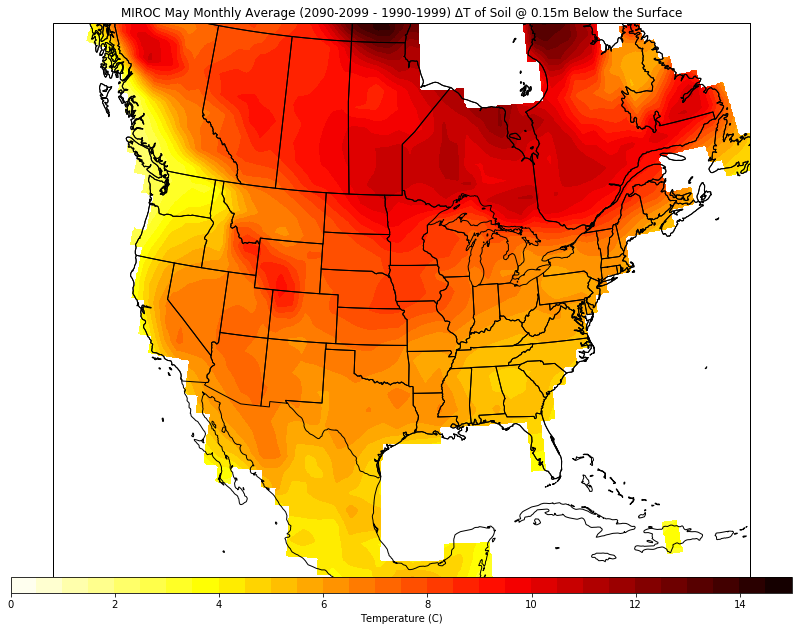

In [9]:
surface_plot(climo_delta_soil_miroc('tsl'), 'MIROC')

Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.


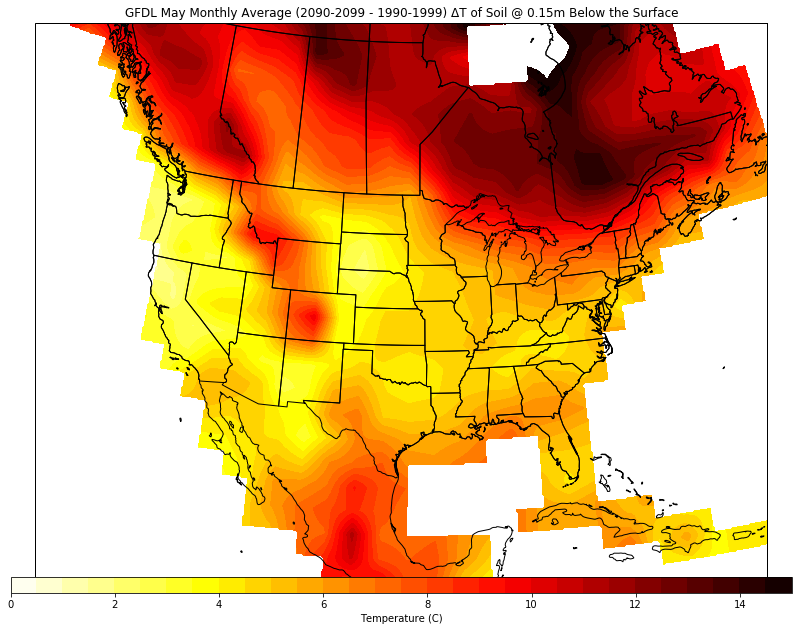

In [10]:
surface_plot(climo_delta_soil_gfdl('tsl'), 'GFDL')

Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable tsl as the horizontal dimensions for this dataset.


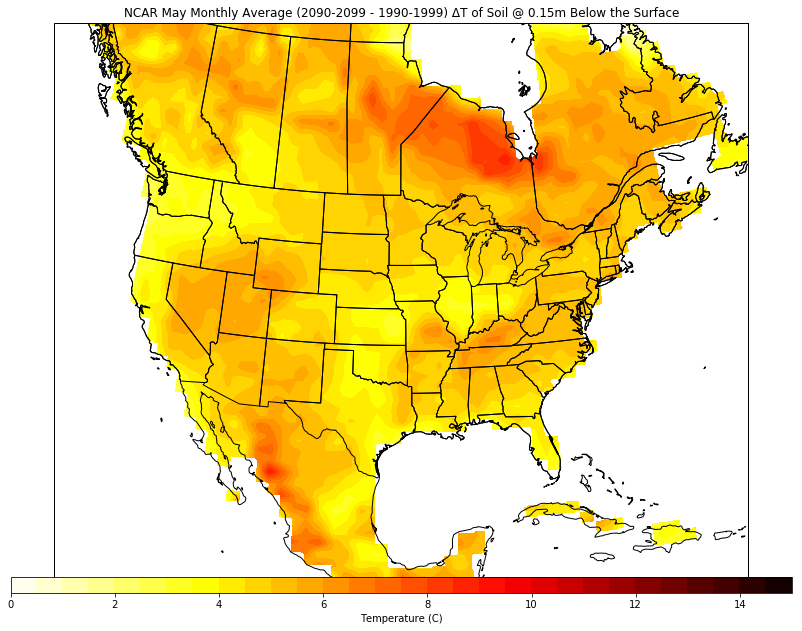

In [11]:
surface_plot(climo_delta_soil_ncar('tsl'), 'NCAR')